<a href="https://colab.research.google.com/github/Anggunasr/MSBA2425/blob/main/Topic_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Topic Modeling with LDA
Topic Modeling is a type of statistical modeling for discovering the abstract "topics" that occur in a collection of documents. It is a frequent technique in text mining for uncovering hidden semantic structures in a text body. This process is useful in various applications like organizing large archives of texts, summarizing information, and aiding in understanding the main themes of texts without reading them in full.


##Install Packages

In [8]:
!pip install gensim

**Select Runtime-Restart session after installing gensim**

In [7]:
# !pip install numpy==1.24.4

In [9]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer, SnowballStemmer
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [10]:
import gensim
from gensim.corpora import Dictionary
from gensim.models import LdaModel

##Read and Preprocess Data

In [11]:
# Function to preprocess the data
def preprocess_texts(documents):
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()

    preprocessed_texts = []
    for text in documents:
        text = text.lower()
        tokens = nltk.word_tokenize(text)
        tokens = [token for token in tokens if token not in stop_words and token.isalpha()]
        tokens = [lemmatizer.lemmatize(token) for token in tokens]
        preprocessed_texts.append(tokens)  # Append list of tokens directly, without joining them into a string

    return preprocessed_texts


In [12]:
import pandas as pd

In [13]:
df = pd.read_csv('oct_delta.csv')

In [14]:
texts = preprocess_texts(df['text'])
dictionary = Dictionary(texts)

# Create a document-term matrix
corpus = [dictionary.doc2bow(text) for text in texts]

##LDA

In [17]:
# Set parameters
num_topics = 2
passes = 10

# Create the LDA model
lda = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=passes)

# Display the topics
topics = lda.print_topics(num_words=10)
for topic in topics:
    print(topic)


(0, '0.018*"flight" + 0.016*"hi" + 0.014*"thanks" + 0.014*"please" + 0.013*"pl" + 0.012*"look" + 0.012*"thank" + 0.010*"welcome" + 0.010*"take" + 0.009*"number"')
(1, '0.023*"sorry" + 0.021*"pls" + 0.019*"please" + 0.018*"team" + 0.017*"hear" + 0.014*"confirmation" + 0.012*"assistance" + 0.012*"hi" + 0.012*"dm" + 0.011*"let"')


The variations in output each time you run an LDA model are due to the stochastic nature of the algorithms used in Latent Dirichlet Allocation. Here are the key reasons for these variations:

* Random Initialization: Most LDA implementations (including gensim) start with a random initialization of the topic assignments for each word. This randomness affects the subsequent updates and iterations of the algorithm.

* Sampling Methods: LDA often uses sampling methods like Gibbs sampling or variational Bayes inference to estimate the distributions of topics over words and documents. These methods inherently involve randomness, which can lead to different results each time the model is trained, especially if the number of iterations is not large enough to reach convergence.

* Convergence Issues: If the LDA model doesn't fully converge due to too few iterations or poor parameter settings (like learning rates), the output may vary significantly between runs. Achieving convergence in probabilistic models can be challenging and might require tuning parameters such as the number of iterations and choosing appropriate hyperparameters (like alpha and beta for LDA).

* Number of Topics: The choice of the number of topics (num_topics) can also influence the stability of your topics. Too few or too many topics can lead to overfitting or underfitting, respectively, making the model sensitive to initial conditions or specific samples of data.

### Ensuring Consistency

To reduce the variability in your LDA models, you can take the following steps:

* Set a Random Seed: Most LDA implementations allow you to set a random seed to make the results reproducible. This is done by fixing the seed for the random number generator used by the model.

* Increase the Number of Iterations: Allowing more iterations can help the model converge more consistently, which, in turn, makes the output more stable.

* Tune Hyperparameters: Adjusting the hyperparameters, such as alpha (document-topic density) and beta (topic-word density), can help in achieving better and more consistent results. These parameters control the sparsity of the topics extracted by the model.

* Extensive Preprocessing: More consistent and thorough preprocessing of the text data can lead to less noise in the input, which helps stabilize the output.

```
lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=10,
    random_state=100,
    update_every=1,
    chunksize=100,
    passes=10,
    alpha='auto',  # can be set as a scalar like '0.01' or 'auto' for learning the optimal alpha
    eta='auto'     # eta is another name for beta in gensim, similarly settable
)
```




In [ ]:
# Set parameters
num_topics = 3
passes = 10

# Create the LDA model
lda = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=passes,random_state=100)

# Display the topics
topics = lda.print_topics(num_words=5)
for topic in topics:
    print(topic)


We can also display the topics as wordclouds:

In [18]:
%pip install wordcloud

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.11/dist-packages/matplotlib/pyplot.py'>

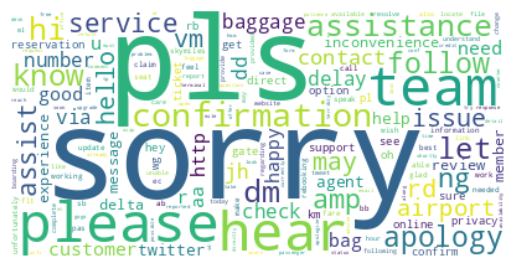

In [19]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def create_wordcloud(model, topic):
    text = {word: value for word, value in model.show_topic(topic, 200)}
    wc = WordCloud(background_color="white", max_words=1000)
    wc.generate_from_frequencies(text)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    return plt

create_wordcloud(lda, topic=1)

##Coherence Score
Coherence measures the degree of semantic similarity between high scoring words in the topic. These scores help distinguish between topics that are semantically interpretable topics and topics that are artifacts of statistical inference.

In [15]:
from gensim.models.coherencemodel import CoherenceModel
coherence_model_lda = CoherenceModel(model=lda, texts=texts, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score:', coherence_lda)


NameError: name 'lda' is not defined

## Number of Topics

[0.2999784444687522, 0.33732166754821225, 0.30331947812237325, 0.3275518902204905, 0.30912691157215977, 0.3258845719623117]


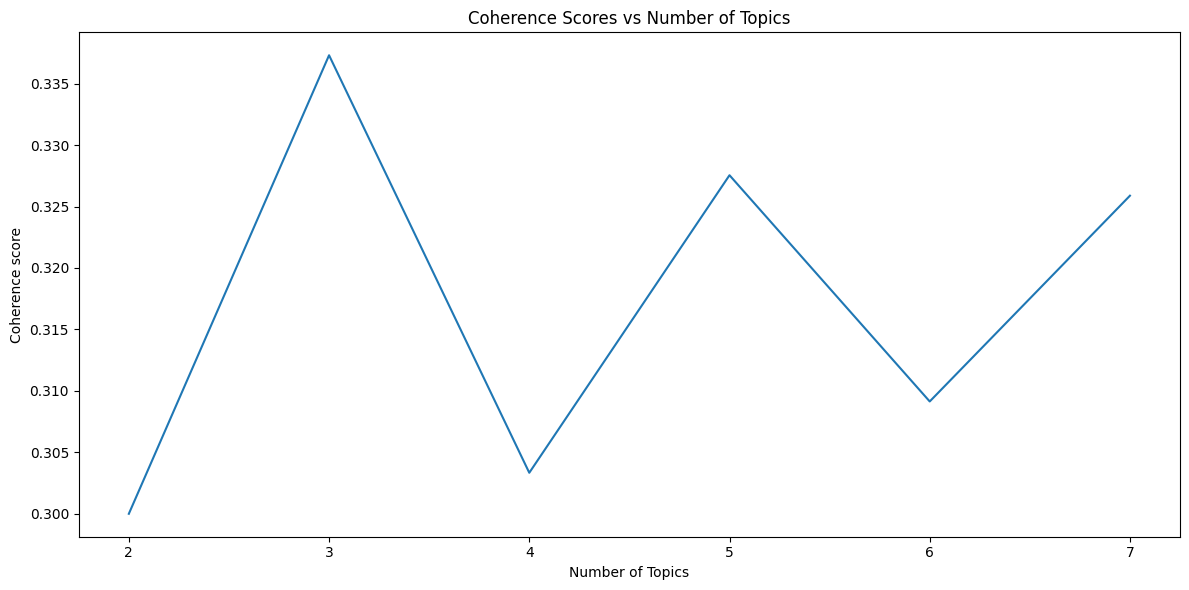

In [20]:
import matplotlib.pyplot as plt

# Range of topics to evaluate
topic_range = range(2, 8)

# List to store coherence
coherence_scores = []

for num_topics in topic_range:
    lda = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=passes, random_state=100)
    # Initialize CoherenceModel after training the LDA model
    coherence_model_lda = CoherenceModel(model=lda, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()

    # Append the coherence score
    coherence_scores.append(coherence_lda)

print(coherence_scores)
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(topic_range, coherence_scores)
plt.title("Coherence Scores vs Number of Topics")
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.tight_layout()
plt.show()


##Select the Final Model

In [23]:
# Set parameters
num_topics = 3

# Create the LDA model
lda = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=passes,random_state=100)

# Display the topics
topics = lda.print_topics(num_words=5)
for topic in topics:
    print(topic)


(0, '0.021*"sorry" + 0.020*"pls" + 0.019*"hear" + 0.016*"let" + 0.016*"team"')
(1, '0.036*"please" + 0.028*"confirmation" + 0.024*"dm" + 0.023*"number" + 0.017*"follow"')
(2, '0.020*"hi" + 0.016*"thank" + 0.013*"thanks" + 0.011*"team" + 0.011*"sorry"')


## Top terms for each topic

In [24]:
# Print the top 10 terms for each topic
for topic_id in range(num_topics):
    top_terms = lda.show_topic(topic_id, topn=10)  # Get the top 10 terms for this topic
    terms = ', '.join([term for term, _ in top_terms])
    print(f"Topic {topic_id}: {terms}")

Topic 0: sorry, pls, hear, let, team, know, assistance, ng, good, flight
Topic 1: please, confirmation, dm, number, follow, look, take, hi, pl, amp
Topic 2: hi, thank, thanks, team, sorry, flight, u, issue, aa, http


## Interactive Web-based Visualization

In [25]:
%pip install pyLDAvis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 78.3 MB/s eta 0:00:00


In [26]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

# Assume `lda` is the LDA model and `corpus` and `dictionary` are your corpus and dictionary from Gensim

# Prepare the visualization data
vis_data = gensimvis.prepare(lda, corpus, dictionary)

# Display the visualization in a Jupyter Notebook (or in an IPython environment)
pyLDAvis.display(vis_data)

# To save the visualization as an HTML file
pyLDAvis.save_html(vis_data, 'lda_visualization.html')


# Your Turn
Conduct topic modeling with `sms_spam.csv`and `oct_delta.csv` data.